# Jupyter Example 4 for HERMES: Gamma-ray Spectrum from Diffuse Emissions

In [1]:
from pyhermes import *
from pyhermes.units import *

import astropy.units as u

import numpy as np
import healpy
import matplotlib.pyplot as plt

In [2]:
def integrate_template(integrator, nside):
    
    integrator.setupCacheTable(60, 60, 12)
    sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
    integrator.setObsPosition(sun_pos)
    
    mask_edges = ([5*deg, 0*deg], [-5*deg, 180*deg])
    mask = RectangularWindow(*mask_edges)
    
    skymap_range = GammaSkymapRange(nside, 1*GeV, 100*TeV, 15)
    skymap_range.setIntegrator(integrator)
    skymap_range.setMask(mask)
    
    skymap_range.compute()
    
    return skymap_range

def integrate_pizero(gas):
    nside = 256
    protons = Dragon2DCRDensity([Proton])
    integrator = PiZeroIntegrator(protons, gas, Kamae06())
    return integrate_template(integrator, nside)

def integrate_bremss(gas):
    nside = 256
    leptons = Dragon2DCRDensity([Electron, Positron])
    integrator = PiZeroIntegrator(leptons, gas, BremsstrahlungSimple())
    return integrate_template(integrator, nside)

def integrate_IC():
    nside = 128
    leptons = Dragon2DCRDensity([Electron, Positron])
    integrator = InverseComptonIntegrator(leptons, ISRF(), KleinNishina())    
    return integrate_template(integrator, nside)

In [3]:
# Neutral gas contained in the so-called ring model
neutral_gas_HI = RingModelDensity(RingType.HI)
neutral_gas_CO = RingModelDensity(RingType.CO)

In [4]:
# Produce first Pi0 skymaps for HI and CO
skymap_range_pi0_HI = integrate_pizero(neutral_gas_HI)
skymap_range_pi0_CO = integrate_pizero(neutral_gas_CO)

In [5]:
#skymap_range_bremss_HI = integrate_bremss(neutral_gas_HI)
#skymap_range_bremss_CO = integrate_bremss(neutral_gas_CO)

In [6]:
skymap_range_IC = integrate_IC()

In [7]:
#use_units = skymap_range_HI[0].getUnits() # default units for GammaSkymap (GeV^-1 m^-2 s^-1 sr^-1)
use_units = "GeV^-1 cm^-2 s^-1 sr^-1" # override default
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

In [8]:
def calc_mean_flux(skymap_range):
    energies = np.array([float(s.getEnergy()/GeV) for s in skymap_range])
    fluxes = np.array([s.getMean() for s in skymap_range]) / base_units
    return energies, fluxes

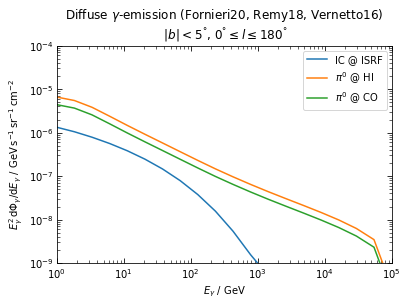

In [24]:
def plot_spectrum(skymap_range, label):
    energies, fluxes = calc_mean_flux(skymap_range)
    plt.plot(energies, fluxes*energies**2, '-', label=label)

fig, ax = plt.subplots()

plot_spectrum(skymap_range_IC, r'IC @ ISRF')
plot_spectrum(skymap_range_pi0_HI, r'$\pi^0$ @ HI')
plot_spectrum(skymap_range_pi0_CO, r'$\pi^0$ @ CO')
#plot_spectrum(skymap_range_bremss_HI, r'Bremss. @ HI')
#plot_spectrum(skymap_range_bremss_CO, r'Bremss. @ CO')

plt.title("Diffuse $\gamma$-emission (Fornieri20, Remy18, Vernetto16)\n $|b| < 5^\degree$, $0^\degree \leq l \leq 180^\degree$")
plt.legend()

plt.xlabel("$E_\gamma$ / GeV")
plt.ylabel("$E_\gamma^2\, \mathrm{d}\Phi_\gamma / \mathrm{d} E_\gamma$ / " + (skymap_units*u.GeV**2).unit.to_string(format='latex_inline'))

ax.tick_params(which='minor', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=3)
ax.tick_params(which='major', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=5)
plt.xscale("log")
plt.yscale("log")

plt.ylim(10**(-9), 10**(-4))
plt.xlim(10**(0), 10**(5))

plt.savefig("diffuse-gamma-emission-spectrum-180-pi0+ic+bs.pdf", dpi=150)